In [2]:
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
import time
import numpy as np
from qiskit import *
from qiskit import IBMQ
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_finance.circuit.library import LogNormalDistribution

## 1. Option params

In [3]:
# parameters for considered random distribution
S = 200  # initial spot price
vol = 0.3  # volatility of 30%
r = 0.01  # annual interest rate of 1%
T = 100 / 365  # 100 days to maturity
strike_price = 186

## 2.black scholes

In [4]:
from scipy.stats import norm,kstest,shapiro,t
def black_scholes(S,K,T,r,q,sigma,call=True):
    d1 = (np.log(S/K)+(r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    if call==True:
        return S*np.exp(-q*T)*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2)-S*np.exp(-q*T)*norm.cdf(-d1)
    
bs_price = black_scholes(S,strike_price,T,r,0,vol,call=True)
bs_price

20.674214910370154

## Classical Monte Carlo Simulation

In [5]:
def geo_paths(S, T, r, q, sigma, steps, N):
    """
    Inputs
    #S = Current stock Price
    #K = Strike Price
    #T = Time to maturity 1 year = 1, 1 months = 1/12
    #r = risk free interest rate
    #q = dividend yield
    # sigma = volatility 
    
    Output
    # [steps,N] Matrix of asset paths 
    """
    dt = T/steps
    #S_{T} = ln(S_{0})+\int_{0}^T(\mu-\frac{\sigma^2}{2})dt+\int_{0}^T \sigma dW(t)
    ST = np.log(S) +  np.cumsum(((r - q - sigma**2/2)*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=(steps,N))),axis=0)
    
    return np.exp(ST)



In [6]:

mape_classical = []
payoff_classical = []
runtime_classical = []
for q in range(1,12):
    time_start = time.time()
    est_prices = []

    steps = 100 # time steps
    N = 2**q # number of trials

    for i in range(4000):
        paths= geo_paths(S,T,r, 0,vol,steps,N)
        payoffs = np.maximum(paths[-1]-strike_price, 0)
        option_price = np.mean(payoffs)*np.exp(-r*T) #discounting back to present value
        est_prices.append(option_price)


    time_end = time.time()
    MAPE_classical_mc = np.mean(np.abs((bs_price - est_prices) / bs_price))
    payoff_classical.append(est_prices[-1])
    mape_classical.append(MAPE_classical_mc)
    runtime_classical.append(time_end-time_start)
    print(f"Number of Samples: {N}")
    print(f"classical computer MC MAPE is {round(MAPE_classical_mc*100,4)}%")
    print(f"running time on simulator: {time_end-time_start}")

Number of Samples: 2
classical computer MC MAPE is 68.9853%
running time on simulator: 0.14059805870056152
Number of Samples: 4
classical computer MC MAPE is 47.6488%
running time on simulator: 0.14094901084899902
Number of Samples: 8
classical computer MC MAPE is 33.3671%
running time on simulator: 0.19440793991088867
Number of Samples: 16
classical computer MC MAPE is 24.1673%
running time on simulator: 0.2947530746459961
Number of Samples: 32
classical computer MC MAPE is 17.2393%
running time on simulator: 0.4968910217285156
Number of Samples: 64
classical computer MC MAPE is 12.0513%
running time on simulator: 0.913916826248169
Number of Samples: 128
classical computer MC MAPE is 8.4125%
running time on simulator: 1.7386279106140137
Number of Samples: 256
classical computer MC MAPE is 5.9838%
running time on simulator: 3.771589756011963
Number of Samples: 512
classical computer MC MAPE is 4.2099%
running time on simulator: 8.365385055541992
Number of Samples: 1024
classical comput

In [7]:
time_start = time.time()


steps = 1 # time steps
N = 2**14 # number of trials

for i in range(100):
    paths= geo_paths(S,T,r, 0,vol,steps,N)
    payoffs = np.maximum(paths[-1]-strike_price, 0)
    option_price = np.mean(payoffs)*np.exp(-r*T) #discounting back to present value


time_end = time.time()
MAPE_classical_mc = np.mean(np.abs((bs_price - option_price) / bs_price))

print(f"Number of Samples: {N}")
print(f"classical computer MC MAPE is {round(MAPE_classical_mc*100,4)}%")
print(f"running time on simulator: {time_end-time_start}")

Number of Samples: 16384
classical computer MC MAPE is 1.1008%
running time on simulator: 0.08637070655822754


Text(0.5, 1.0, 'Geometric Brownian Motion')

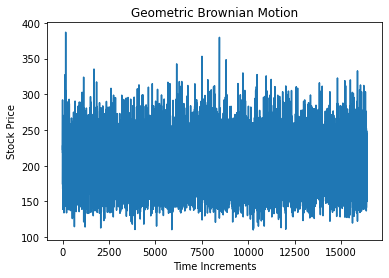

In [8]:
# print(paths[-1])
plt.plot(paths[-1]);
plt.xlabel("Time Increments")
plt.ylabel("Stock Price")
plt.title("Geometric Brownian Motion")

Text(0.5, 1.0, 'Geometric Brownian Motion')

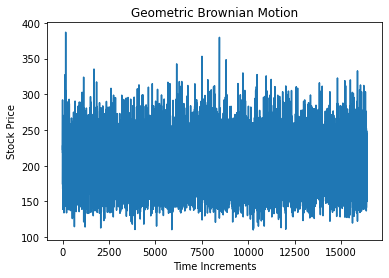

In [9]:
# print(paths[-1])
plt.plot(paths[-1]);
plt.xlabel("Time Increments")
plt.ylabel("Stock Price")
plt.title("Geometric Brownian Motion")

In [10]:
def Function_runtime(func,*args, **kwargs):
    start = timeit.default_timer()
    result = func(*args, **kwargs)
    
    stop = timeit.default_timer()
    time = stop-start
    return result, time

In [11]:

mape_quantum = []
payoff_quantum = []
runtime_quantum = []
for q in range(1,12):
    time_start = time.time()

    # number of qubits to represent the uncertainty
    num_uncertainty_qubits = q


    # resulting parameters for log-normal distribution
    mu = (r - 0.5 * vol**2) * T + np.log(S)
    sigma = vol * np.sqrt(T)
    mean = np.exp(mu + sigma**2 / 2)
    variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
    stddev = np.sqrt(variance)

    # lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
    low = np.maximum(0, mean - 3 * stddev)
    high = mean + 3 * stddev

    # construct A operator for QAE for the payoff function by
    # composing the uncertainty model and the objective
    uncertainty_model = LogNormalDistribution(
        num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
    )

    # set the approximation scaling for the payoff function
    c_approx = 0.25

    # setup piecewise linear objective fcuntion
    breakpoints = [low, strike_price]
    slopes = [0, 1]
    offsets = [0, 0]
    f_min = 0
    f_max = high - strike_price
    european_call_objective = LinearAmplitudeFunction(
        num_uncertainty_qubits,
        slopes,
        offsets,
        domain=(low, high),
        image=(f_min, f_max),
        breakpoints=breakpoints,
        rescaling_factor=c_approx,
    )


    # construct A operator for QAE for the payoff function by
    # composing the uncertainty model and the objective
    num_qubits = european_call_objective.num_qubits
    european_call = QuantumCircuit(num_qubits)
    european_call.append(uncertainty_model, range(num_uncertainty_qubits))
    european_call.append(european_call_objective, range(num_qubits))

    # draw the circuit
    european_call.draw()

    from qiskit_finance.applications.estimation import EuropeanCallPricing

    european_call_pricing = EuropeanCallPricing(
        num_state_qubits=num_uncertainty_qubits,
        strike_price=strike_price,
        rescaling_factor=c_approx,
        bounds=(low, high),
        uncertainty_model=uncertainty_model,
    )

    epsilon = 0.1
    alpha = 0.05

    # exact_value = np.dot(uncertainty_model.probabilities, y)
    # qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=4000)
    statevector_simulator = AerSimulator(method='statevector',shots=4000)
    # extended_stabilizer_simulator = AerSimulator(method='extended_stabilizer')
    problem = european_call_pricing.to_estimation_problem()
    # construct amplitude estimation
    ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=statevector_simulator)
    result = ae.estimate(problem)

    conf_int = np.array(result.confidence_interval_processed)
    ev_option = european_call_pricing.interpret(result)
    # print("Exact value:        \t%.4f" % exact_value)
    print(f"Number of Samples: {2**q}")
    print("Estimated value:    \t%.4f" % (ev_option))
#     print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))
    time_end = time.time()
    runtime_quantum.append(time_end-time_start)
    print(f"running time on simulator: {time_end-time_start}")
    MAPE_qc_simulator = np.abs(ev_option-bs_price)/bs_price
    print(f"QC MC MAPE is {round(MAPE_qc_simulator*100,4)}%")
    mape_quantum.append(MAPE_qc_simulator)
    payoff_quantum.append(ev_option)

Number of Samples: 2
Estimated value:    	105.8080
running time on simulator: 1.0245640277862549
QC MC MAPE is 411.7874%
Number of Samples: 4
Estimated value:    	22.1587
running time on simulator: 0.09283685684204102
QC MC MAPE is 7.1802%
Number of Samples: 8
Estimated value:    	20.5716
running time on simulator: 0.20656895637512207
QC MC MAPE is 0.4962%
Number of Samples: 16
Estimated value:    	21.1026
running time on simulator: 0.21802592277526855
QC MC MAPE is 2.072%
Number of Samples: 32
Estimated value:    	20.9485
running time on simulator: 0.41384315490722656
QC MC MAPE is 1.3266%
Number of Samples: 64
Estimated value:    	20.9209
running time on simulator: 0.7279098033905029
QC MC MAPE is 1.1933%
Number of Samples: 128
Estimated value:    	20.8969
running time on simulator: 1.5571260452270508
QC MC MAPE is 1.0772%
Number of Samples: 256
Estimated value:    	20.8856
running time on simulator: 3.4965150356292725
QC MC MAPE is 1.0226%
Number of Samples: 512
Estimated value:    

In [ ]:
mape_quantum

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot([f"{2**q}" for q in range(2,12)],mape_classical[1:], label = 'Classical Monte Carlo')
ax.plot([f"{2**q}" for q in range(2,12)],mape_quantum[1:], label = 'Quantum')
ax.set_title("Estimation Error")
ax.set_xlabel("Number of Samples")
ax.set_ylabel("MAPE")
ax.legend()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot([f"{2**q}" for q in range(2,12)],payoff_classical[1:], label = 'Classical Monte Carlo')
ax.plot([f"{2**q}" for q in range(2,12)],payoff_quantum[1:], label = 'Quantum')
ax.plot([f"{2**q}" for q in range(2,12)],[bs_price]*10, label = 'Black Scholes')
ax.set_title("Option Price")
ax.set_xlabel("Number of Samples")
ax.set_ylabel("Payoff")
ax.legend()

In [ ]:
runtime_quantum

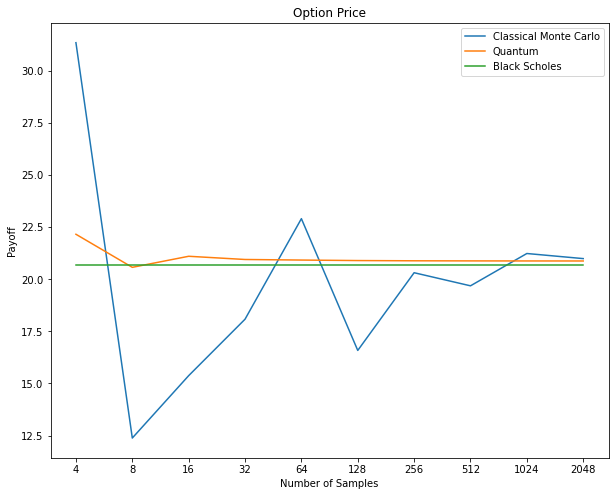

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot([f"{2**q}" for q in range(2,12)],payoff_classical[1:], label = 'Classical Monte Carlo')
ax.plot([f"{2**q}" for q in range(2,12)],payoff_quantum[1:], label = 'Quantum')
ax.plot([f"{2**q}" for q in range(2,12)],[bs_price]*10, label = 'Black Scholes')
ax.set_title("Option Price")
ax.set_xlabel("Number of Samples")
ax.set_ylabel("Payoff")
ax.legend()

In [17]:
runtime_quantum

[1.0245640277862549,
 0.09283685684204102,
 0.20656895637512207,
 0.21802592277526855,
 0.41384315490722656,
 0.7279098033905029,
 1.5571260452270508,
 3.4965150356292725,
 8.499259948730469,
 23.080307006835938,
 75.86083722114563]

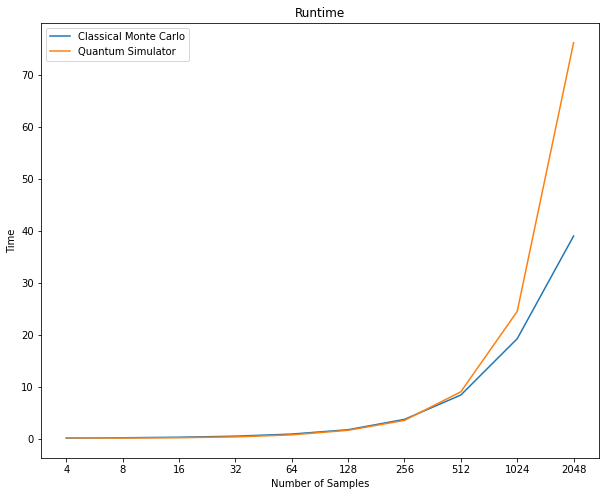

In [10]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot([f"{2**q}" for q in range(2,12)],runtime_classical[1:], label = 'Classical Monte Carlo')
ax.plot([f"{2**q}" for q in range(2,12)],runtime_quantum[1:], label = 'Quantum Simulator')
ax.set_title("Runtime")
ax.set_xlabel("Number of Samples")
ax.set_ylabel("Time")
ax.legend()

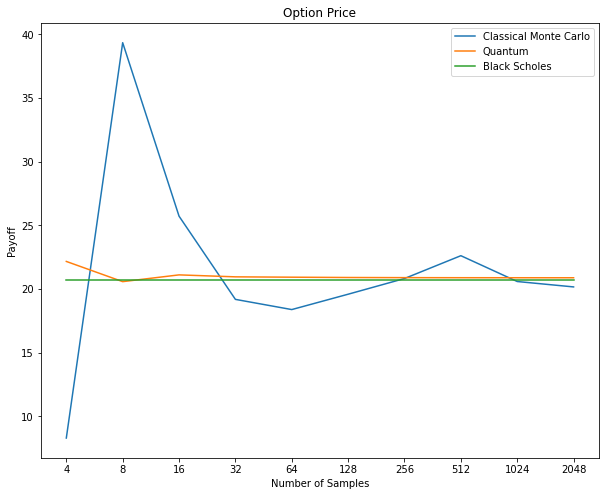

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot([f"{2**q}" for q in range(2,12)],payoff_classical[1:], label = 'Classical Monte Carlo')
ax.plot([f"{2**q}" for q in range(2,12)],payoff_quantum[1:], label = 'Quantum')
ax.plot([f"{2**q}" for q in range(2,12)],[bs_price]*10, label = 'Black Scholes')
ax.set_title("Option Price")
ax.set_xlabel("Number of Samples")
ax.set_ylabel("Payoff")
ax.legend()

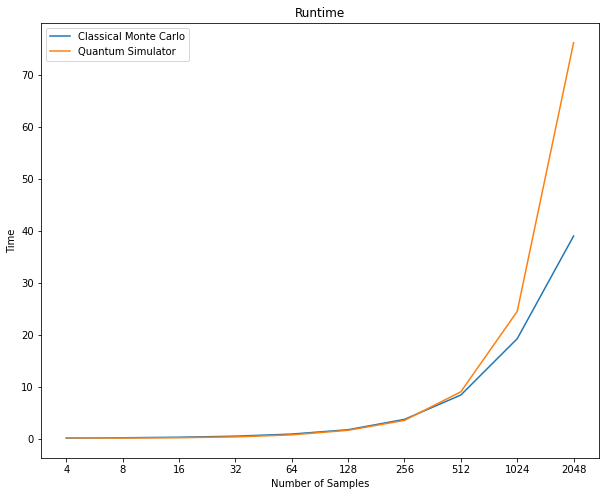

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot([f"{2**q}" for q in range(2,12)],runtime_classical[1:], label = 'Classical Monte Carlo')
ax.plot([f"{2**q}" for q in range(2,12)],runtime_quantum[1:], label = 'Quantum Simulator')
ax.set_title("Runtime")
ax.set_xlabel("Number of Samples")
ax.set_ylabel("Time")
ax.legend()

In [ ]:
# fig, ax = plt.subplots(1,1,figsize=(15,8))
# # plot probability distribution
# x = uncertainty_model.values
# y = uncertainty_model.probabilities
# ax.bar(x, y)
# plt.xticks(x, size=15, rotation=90)
# plt.yticks(size=15)
# plt.grid()
# plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
# plt.ylabel("Probability ($\%$)", size=15)
# plt.show()


In [ ]:
## Real QC running

In [ ]:
IBMQ.save_account("2377ac879cf1f5b0d4a0660ee22f22f8cdf2cb39fe123c8d67b88cf5a64257909d14e84c1a43ee83c212d805a3987f7ee3da2da42fff0e35bf6de15220d1e41b")
IBMQ.load_account()

In [ ]:
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibm_nairobi')

In [ ]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 2



# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)


# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.draw()

from qiskit_finance.applications.estimation import EuropeanCallPricing

european_call_pricing = EuropeanCallPricing(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

epsilon = 0.01
alpha = 0.05

In [ ]:
problem_qc = european_call_pricing.to_estimation_problem()
# construct amplitude estimation
ae_qc = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qcomp)

result_qc = ae_qc.estimate(problem_qc)

In [ ]:

conf_int = np.array(result_qc.confidence_interval_processed)
# print("Exact value:        \t%.4f" % exact_value)

print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result_qc)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))
np.abs(bs_price - 36.8) / bs_price

In [ ]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 3

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)


# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.draw()

from qiskit_finance.applications.estimation import EuropeanCallPricing

european_call_pricing = EuropeanCallPricing(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

epsilon = 0.01
alpha = 0.05

In [ ]:
problem_qc_3q = european_call_pricing.to_estimation_problem()
# construct amplitude estimation
ae_qc_3q = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qcomp2)

result_qc_3q = ae_qc.estimate(problem_qc_3q)

In [ ]:

conf_int_3q = np.array(result_qc_3q.confidence_interval_processed)
# print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result_qc_3q)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int_3q))
np.abs(bs_price - 54.8) / bs_price

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot([f"{2**q}" for q in range(2,12)],mape_classical[1:], label = 'Classical Monte Carlo')
ax.plot([f"{2**q}" for q in range(2,12)],mape_quantum[1:], label = 'Quantum Simulator')
ax.plot([f"{2**q}" for q in range(2,4)],[0.78, 1.65], label = '7-Qubit IBM Quantum Computer')
ax.set_title("Estimation Error")
ax.set_xlabel("Number of Samples")
ax.set_ylabel("MAPE")
ax.legend()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot([f"{2**q}" for q in range(2,12)],payoff_classical[1:], label = 'Classical Monte Carlo')
ax.plot([f"{2**q}" for q in range(2,12)],payoff_quantum[1:], label = 'Quantum Simulator')
ax.plot([f"{2**q}" for q in range(2,12)],[bs_price]*10, label = 'Black Scholes')
ax.plot([f"{2**q}" for q in range(2,4)],[36.8, 54.8], label = '7-Qubit IBM Quantum Computer')
ax.set_title("Option Price")
ax.set_xlabel("Number of Samples")
ax.set_ylabel("Payoff")
ax.legend()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot([f"{2**q}" for q in range(2,12)],runtime_classical[1:], label = 'Classical Monte Carlo')
ax.plot([f"{2**q}" for q in range(2,12)],runtime_quantum[1:], label = 'Quantum Simulator')
ax.plot([f"{2**q}" for q in range(2,4)],[3.8, 5.6], label = '7-Qubit IBM Quantum Computer')
ax.set_title("Runtime")
ax.set_xlabel("Number of Samples")
ax.set_ylabel("Time")
ax.legend()

In [ ]:


# exact_value = np.dot(uncertainty_model.probabilities, y)
qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=10000)
problem = european_call_pricing.to_estimation_problem()
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result = ae.estimate(problem)

conf_int = np.array(result.confidence_interval_processed)
# print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

In [ ]:
MAPE_qc_simulator = np.abs(european_call_pricing.interpret(result)-bs_price)/bs_price
print(f"classical computer MC MAPE is {round(MAPE_qc_simulator*100,4)}%")

In [ ]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=4)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()


In [ ]:
x

In [ ]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [ ]:
IBMQ.save_account("2377ac879cf1f5b0d4a0660ee22f22f8cdf2cb39fe123c8d67b88cf5a64257909d14e84c1a43ee83c212d805a3987f7ee3da2da42fff0e35bf6de15220d1e41b")
IBMQ.load_account()

In [ ]:
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibm_nairobi')

In [ ]:
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibm_nairobi')

In [ ]:
problem_qc = european_call_pricing.to_estimation_problem()
# construct amplitude estimation
ae_qc = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qcomp)

result_qc = ae_qc.estimate(problem_qc)

In [ ]:

conf_int = np.array(result_qc.confidence_interval_processed)
# print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result_qc)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

In [ ]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 2



# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)


# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.draw()

from qiskit_finance.applications.estimation import EuropeanCallPricing

european_call_pricing = EuropeanCallPricing(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

epsilon = 0.01
alpha = 0.05

# exact_value = np.dot(uncertainty_model.probabilities, y)
qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=10000)
problem = european_call_pricing.to_estimation_problem()
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result = ae.estimate(problem)

conf_int = np.array(result.confidence_interval_processed)
# print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

In [ ]:
MAPE_qc_simulator = np.abs(european_call_pricing.interpret(result)-bs_price)/bs_price
print(f"classical computer MC MAPE is {round(MAPE_qc_simulator*100,4)}%")

In [ ]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=4)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()


In [ ]:
x

In [ ]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [ ]:
IBMQ.save_account("2377ac879cf1f5b0d4a0660ee22f22f8cdf2cb39fe123c8d67b88cf5a64257909d14e84c1a43ee83c212d805a3987f7ee3da2da42fff0e35bf6de15220d1e41b")
IBMQ.load_account()

In [ ]:
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_belem')

In [ ]:
problem_qc = european_call_pricing.to_estimation_problem()
# construct amplitude estimation
ae_qc = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qcomp)

result_qc = ae_qc.estimate(problem_qc)

In [ ]:

conf_int = np.array(result_qc.confidence_interval_processed)
# print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result_qc)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

In [ ]:
MAPE_qc_simulator = np.abs(european_call_pricing.interpret(result)-bs_price)/bs_price
print(f"classical computer MC MAPE is {round(MAPE_qc_simulator*100,4)}%")

In [ ]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=4)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()


In [ ]:
x

In [ ]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [ ]:
IBMQ.save_account("2377ac879cf1f5b0d4a0660ee22f22f8cdf2cb39fe123c8d67b88cf5a64257909d14e84c1a43ee83c212d805a3987f7ee3da2da42fff0e35bf6de15220d1e41b")
IBMQ.load_account()

In [ ]:
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_belem')

In [ ]:
problem_qc = european_call_pricing.to_estimation_problem()
# construct amplitude estimation
ae_qc = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qcomp)

result_qc = ae_qc.estimate(problem_qc)

In [ ]:

conf_int = np.array(result_qc.confidence_interval_processed)
# print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result_qc)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

In [ ]:
# number of qubits to represent the uncertainty
time_start = time.time()
num_uncertainty_qubits = 2



# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)


# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.draw()

from qiskit_finance.applications.estimation import EuropeanCallPricing

european_call_pricing = EuropeanCallPricing(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

epsilon = 0.01
alpha = 0.05

# exact_value = np.dot(uncertainty_model.probabilities, y)
qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=4000)
problem = european_call_pricing.to_estimation_problem()
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result = ae.estimate(problem)

conf_int = np.array(result.confidence_interval_processed)
# print("Exact value:        \t%.4f" % exact_value)
time_end = time.time()
print(f"running time on simulator: {time_end-time_start}")
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

In [ ]:
Aer.backends()

In [88]:
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]